<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Method-using-a-simple-function" data-toc-modified-id="1.-Method-using-a-simple-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Method using a simple function</a></span></li><li><span><a href="#2.-Integration-method-by-meta" data-toc-modified-id="2.-Integration-method-by-meta-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Integration method by meta</a></span></li></ul></div>

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
sys.path.append("../")
sys.path.append("../..")

start_time = "2020-08-01 00:00:00"
end_time ="2022-05-01 00:00:00"


refine_param = {
    "removeDuplication":{"flag":True},
    "staticFrequency":{"flag":True, "frequency":None}
}
outlier_param  = {
    "certainErrorToNaN":{"flag":True},
    "unCertainErrorToNaN":{
        "flag":False,
        "param":{}
    }
}
imputation_param = {
        "flag":True,
        "imputation_method":[{"min":0,"max":50,"method":"linear", "parameter":{}}],
        "totalNonNanRatio":80
}
process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}   


## 0. Prepare MultipleDataSet

In [7]:
from clust.ingestion.influx import influx_Client_v2 as influx_Client, multipleDataSets
from setting import influx_setting_KETI as ins

db_client = influx_Client.influxClient(ins.CLUSTDataServer)

from clust.integration.utils import param
startTime = "2016-01-11"
endTime = "2016-04-15"
dataInfo = [['life_indoor_environment', 'humidityTrain_10min'], ['life_indoor_environment', 'temperatureTrain_10min'], 
            ['weather_outdoor_environment', 'belgiumChieverseAirportTrain_10min']]
re_frequency_sec = 4*60
intDataInfo = param.makeIntDataInfoSet(dataInfo, startTime, endTime)
multiple_dataset  = multipleDataSets.get_onlyNumericDataSets(db_client, intDataInfo)

In [8]:
import pandas as pd 
from pandas.tseries.frequencies import to_offset
freq_check_length= 4
test = multiple_dataset[1]
freq = to_offset(pd.infer_freq(test[:freq_check_length].index))
print(freq)

<10 * Minutes>


# 1. Method using a simple function 

In [9]:
from clust.integration.integrationInterface import IntegrationInterface

integrationParam={}
integration_param = {
    "integration_frequency":re_frequency_sec,
    "param":integrationParam,
    "method":"meta",
    "integration_duration":"common"
}

basicDataSet = IntegrationInterface().integrationByInfluxInfo(db_client, intDataInfo, process_param, integration_param )

# 2. Integration method by meta

In [10]:
from clust.preprocessing import dataPreprocessing
#process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}
partialP = dataPreprocessing.DataProcessing(process_param)
multiple_dataset = partialP.multiDataset_all_preprocessing(multiple_dataset)
## Integration
from clust.integration.meta import data_integration
imputed_datas = {}
for key in multiple_dataset.keys():
    imputed_datas[key]=(multiple_dataset[key]["imputed_data"])

In [11]:
data_set = imputed_datas
from clust.integration.meta import partialDataInfo
# 1. Prepare Meta
integration_duration="common"
partial_data_info = partialDataInfo.PartialData(data_set, integration_duration)
# 2. or Define Meta
# TODO
# Integration
re_frequency = datetime.timedelta(seconds= re_frequency_sec)
from clust.integration.meta import data_integration
data_it = data_integration.DataIntegration(data_set)
integrated_data_resample = data_it.dataIntegrationByMeta(re_frequency, partial_data_info.column_meta)

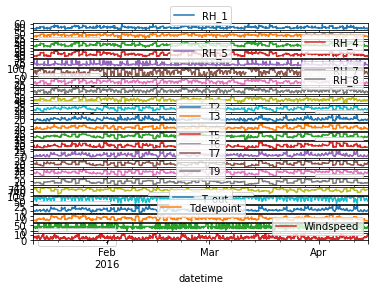

In [12]:
from clust.tool.plot_graph import plot_features
plt.rcParams['figure.figsize'] =(18, 20)
plot_features.plot_all_feature_data(integrated_data_resample)